In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler

from tensorflow.python import debug as tf_debug
#from sklearn.preprocessing import MinMaxScaler ##########

sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/media/controlslab/DATA/Projects')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Grid import GridDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#declare specifics of the ODE
deltas = [10**(-6)]
variable_boundaries = [[0, 1]]
points_per_dimension = [10000]

#Boundary conditions
initial_xs = np.array([[0]])
initial_ys = np.array([[2]])

num_features = len(points_per_dimension)
num_conditions = len(initial_xs)
num_output = 1

#two d-dimensional points for each dimension to compute the derivatives plus the original point
num_fevals = len(points_per_dimension)*2+1 

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

def tf_simple_ode(X):
    
    #l2_lambda_regularization = 0.1
    #l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 50, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         name="fc1")
    y = tf.layers.dense(A1, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape, num_fevals=1, num_conditions=0, alpha=1):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)
    y_pred = tf_simple_ode(X)
    
    loss_function =  loss_functions.residual_function_wrapper(num_features, output_shape, 
                                                                     deltas, num_fevals, num_conditions, alpha)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.8).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

## Create Tunable Model Tensorflow and assign data

### For simple ODE

In [5]:
#scaler = MinMaxScaler()

dhandler_grid = GridDataHandler()

model = tf_compiled_model(num_features=num_features, output_shape=num_output, num_fevals=num_fevals, 
                          num_conditions=num_conditions, alpha=1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_grid, batch_size=256)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, boundaries=variable_boundaries, n=points_per_dimension)

#Real function
tModel.y_test = analytic_functions.ode1(tModel.X_test[:,0])
tModel.y_train = analytic_functions.ode1(tModel.X_train[:,0])
tModel.y_crossVal = analytic_functions.ode1(tModel.X_crossVal[:,0])

tModel.print_data()

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

Loading data for the first time
Reloading data due to parameter change
Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(7200, 1)
(7200, 1)
Cross-Validation data (X, y)
(1

/Users/davidlaredorazo/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [6]:
tModel.epochs = 200
minibatches_function_handle = aux_functions_stochastic.get_minibatches

sess = tf.Session()

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas, initial_xs=initial_xs, initial_ys=initial_ys)

    # cost_reg: total_cost -> e
    # cost: R

Epoch: 0001 cost_reg= 0.577548930 cost= 0.577548930
Epoch: 0002 cost_reg= 0.019645082 cost= 0.019645082
Epoch: 0003 cost_reg= 0.019255616 cost= 0.019255616
Epoch: 0004 cost_reg= 0.019505601 cost= 0.019505601
Epoch: 0005 cost_reg= 0.020409230 cost= 0.020409230
Epoch: 0006 cost_reg= 0.019766097 cost= 0.019766097
Epoch: 0007 cost_reg= 0.019904729 cost= 0.019904729
Epoch: 0008 cost_reg= 0.021034390 cost= 0.021034390
Epoch: 0009 cost_reg= 0.020024688 cost= 0.020024688
Epoch: 0010 cost_reg= 0.020055670 cost= 0.020055670
Epoch: 0011 cost_reg= 0.020508943 cost= 0.020508943
Epoch: 0012 cost_reg= 0.020916819 cost= 0.020916819
Epoch: 0013 cost_reg= 0.019405940 cost= 0.019405940
Epoch: 0014 cost_reg= 0.019025193 cost= 0.019025193
Epoch: 0015 cost_reg= 0.020161865 cost= 0.020161865
Epoch: 0016 cost_reg= 0.019699226 cost= 0.019699226
Epoch: 0017 cost_reg= 0.019721444 cost= 0.019721444
Epoch: 0018 cost_reg= 0.019769131 cost= 0.019769131
Epoch: 0019 cost_reg= 0.020638988 cost= 0.020638988
Epoch: 0020 

Epoch: 0163 cost_reg= 0.005668071 cost= 0.005668071
Epoch: 0164 cost_reg= 0.005213604 cost= 0.005213604
Epoch: 0165 cost_reg= 0.005971844 cost= 0.005971844
Epoch: 0166 cost_reg= 0.005988407 cost= 0.005988407
Epoch: 0167 cost_reg= 0.005934587 cost= 0.005934587
Epoch: 0168 cost_reg= 0.006626672 cost= 0.006626672
Epoch: 0169 cost_reg= 0.005925239 cost= 0.005925239
Epoch: 0170 cost_reg= 0.005330329 cost= 0.005330329
Epoch: 0171 cost_reg= 0.005694131 cost= 0.005694131
Epoch: 0172 cost_reg= 0.004848999 cost= 0.004848999
Epoch: 0173 cost_reg= 0.004689146 cost= 0.004689146
Epoch: 0174 cost_reg= 0.005453526 cost= 0.005453526
Epoch: 0175 cost_reg= 0.006955510 cost= 0.006955510
Epoch: 0176 cost_reg= 0.007061091 cost= 0.007061091
Epoch: 0177 cost_reg= 0.006809869 cost= 0.006809869
Epoch: 0178 cost_reg= 0.007017511 cost= 0.007017511
Epoch: 0179 cost_reg= 0.007238025 cost= 0.007238025
Epoch: 0180 cost_reg= 0.007183511 cost= 0.007183511
Epoch: 0181 cost_reg= 0.006766481 cost= 0.006766481
Epoch: 0182 

In [7]:
display_points = 20

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
y_pred = tModel.y_predicted
y_real = tModel.y_crossVal
print("scores")

print(X_test)
print(y_real)

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(y_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)
print(sample_points)

y_real_sampled = y_real[sample_points]
y_pred_sampled = y_pred[sample_points]
X_sampled = X_test[sample_points,:]

print(y_real_sampled)

i = range(len(y_pred_sampled))


for x, y_real_display, y_pred_display in zip(X_sampled, y_real_sampled, y_pred_sampled):
    print('x {}, Real y {}, Predicted y {}'.format(x, y_real_display, y_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
[[0.9639964 ]
 [0.23862386]
 [0.8709871 ]
 ...
 [0.89118912]
 [0.85088509]
 [0.01640164]]
[[1.38136575]
 [1.78771111]
 [1.41853821]
 ...
 [1.41016772]
 [1.4270368 ]
 [1.98373213]]
[ 510  681  461  245 1362 1484 1016 1063 1101  847  462   62  126 1002
 1114 1134  945  858  320 1343]
[[1.64613703]
 [1.602209  ]
 [1.48691195]
 [1.59806765]
 [1.43392504]
 [1.36979759]
 [1.78425245]
 [1.52175087]
 [1.7691831 ]
 [1.54850436]
 [1.51090728]
 [1.40180388]
 [1.67069557]
 [1.48896149]
 [1.67029323]
 [1.44477755]
 [1.73020392]
 [1.93444101]
 [1.43331791]
 [1.46460084]]
x [0.43674367], Real y [1.64613703], Predicted y [1.6484113]
x [0.50715072], Real y [1.602209], Predicted y [1.6005361]
x [0.71967197], Real y [1.48691195], Predicted y [1.4939752]
x [0.51405141], Real y [1.59806765], Predicted y [1.5958437]
x [0.83488349], Real y [1.43392504], Predicted y [1.4406769]
x [0.99479948], Real y [1.36979759], Predicted y [1.3666978]
x [0.2430243], Real y [1.78425245], Predicted y [1.7817693]
x [0.

In [8]:
x = np.linspace(0, 1, 1000)

y = analytic_functions.ode1(x)

In [9]:
#plt.scatter(X_test.flatten(), y_nn,c='r')  #y_pred
#plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  #y_real

#plt.show()

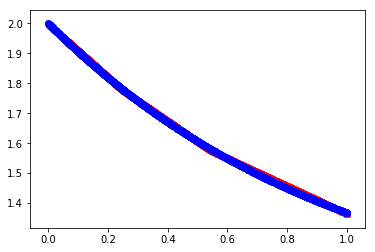

In [10]:
plt.scatter(X_test.flatten(), y_pred.flatten(),c='r')  # y_pred/nn_pred
plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  # y_real
#plt.scatter(x,nn_real,c='b')  #nn_real

plt.show()